In [1]:
import numpy as np, matplotlib.pyplot as plt, matplotlib as mpl
from astropy.io import fits
from astropy.table import Table
from tqdm import tqdm
import pcmdpy as ppy
%matplotlib inline

In [2]:
from pcmdpy.data.alignment import drizzle_image_sets

In [3]:
from pcmdpy.data import sources, utils, extraction

In [4]:
import pandas as pd

# Alignment and Drizzling

In [5]:
files = {'F475W': ['../data/NGC3377/raw/NGC3377_F475W_EXP{:d}_flc.fits'.format(i) for i in range(1, 5)],
         'F850LP': ['../data/NGC3377/raw/NGC3377_F850LP_EXP{:d}_flc.fits'.format(i) for i in range(1, 5)]}
outputs = {'F475W': '../data/NGC3377/reduced/NGC3377_F475W_drc.fits',
          'F850LP': '../data/NGC3377/reduced/NGC3377_F850LP_drc.fits'}
darks = {filt: '../data/NGC3377/calibration/25716350j_drk.fits' for filt in files.keys()}

In [7]:
%%time
drizzle_image_sets(files, outputs, darks)

--Initial Alignment: tweakreg on all files
--Creating temporary dark files
--Drizzling Images with lanczos3 kernel
--Accounting for Dark and Sky Noise


/Users/bcook/pCMDs/pixcmd/pcmdpy/pcmdpy/data/alignment.py:67: RuntimeWarning: invalid value encountered in greater
  too_dark = (dark['SCI'].data > dark_med_factor*dark_med)


Noise Properties
F475W
--Total: 113.5 counts (0.082 cps)
--Sky: 105.8 counts (0.077 cps)
--Dark: 7.6 counts (0.006 cps)
F850LP
--Total: 187.9 counts (0.063 cps)
--Sky: 171.4 counts (0.057 cps)
--Dark: 16.5 counts (0.005 cps)
--Removing temporary files
--Done
CPU times: user 5min 30s, sys: 32.8 s, total: 6min 3s
Wall time: 6min 46s


# Automatic Source Extraction

In [10]:
%%time
box = 8
sources.estimate_background(outputs['F850LP'], bkg_kwargs={'bw':box, 'bh':box})

CPU times: user 14.1 s, sys: 2.58 s, total: 16.6 s
Wall time: 17.4 s


In [12]:
%%time
sources.mask_sources_auto(outputs['F850LP'], threshold=10.0)

CPU times: user 2.48 s, sys: 2.81 s, total: 5.29 s
Wall time: 6.05 s


# Manual Source Extraction

In [13]:
sources.mask_sources_manual(outputs['F850LP'], '../data/NGC3377/masks/NGC3377_F850LP.reg')

In [16]:
# compute regions using only source masks
sources._add_masked(outputs['F850LP'], mask_flags=[utils.ALL_FLAGS['SEXTRACTOR'],
                                                   utils.ALL_FLAGS['MANUAL']])

# Combine Masks

In [6]:
utils.combine_flags(outputs)

# Compute Regions

In [6]:
extraction.add_regions(outputs, '../data/NGC3377/masks/NGC3377_F850LP_contours.reg', base_filter='F850LP')

100%|██████████| 47/47 [01:14<00:00,  1.59s/it]


# Extract PCMDs

In [6]:
pcmds = extraction.save_pcmds(outputs, 'F850LP', 'F475W', path='../data/NGC3377/pcmds/', name_append='NGC3377_z_gz')

Filter: F850LP
Observation Date: 53748 (MJD)
Vega ZeroPoint: 24.3512
AB ZeroPoint: 24.8770
ST ZeroPoint: 25.9650
Exposure Time: 3005.0
A pre-made filter is available
Filter: F475W
Observation Date: 53748 (MJD)
Vega ZeroPoint: 26.1702
AB ZeroPoint: 26.0776
ST ZeroPoint: 25.7668
Exposure Time: 1380.0
A pre-made filter is available


100%|██████████| 188/188 [00:27<00:00,  6.86it/s]


# Check

In [42]:
Neffs = {i: np.sqrt(pcmds[i].shape[1]) for i in range(1, max(pcmds.keys())+1)}

In [43]:
Neffs_by_slice = {i: [Neffs[j] for j in range(4*i, 4*i+4)] for i in range(1, max(pcmds.keys())//4)}

In [8]:
f = ppy.instrument.default_NGC3377_filters()
iso_model = ppy.isochrones.Isochrone_Model(f)

In [9]:
ppy.distancemodels.mpc_to_dmod(11.2)

30.24609011335091

In [18]:
h = fits.open(outputs['F850LP'])
f[0].counts_to_mag(h[0].header['SKYNOISE'])

27.460532954579477

In [47]:
driv = ppy.driver.Driver(iso_model, gpu=False)

In [81]:
gal_3 = ppy.galaxy.SSPSimple(np.array([0., -2., 3., 10.]), dmod=30.)
gal_4 = ppy.galaxy.SSPSimple(np.array([0., -2., 4., 10.]), dmod=30.)
gal_5 = ppy.galaxy.SSPSimple(np.array([0., -2., 5., 10.]), dmod=30.)
gal_6 = ppy.galaxy.SSPSimple(np.array([0., -2., 6., 10.]), dmod=30.)

In [82]:
pcmd_3, _ = driv.simulate(gal_3, 128, sky_noise=[140., 90.])
pcmd_4, _ = driv.simulate(gal_4, 128, sky_noise=[140., 90.])
pcmd_5, _ = driv.simulate(gal_5, 128, sky_noise=[140., 90.])
pcmd_6, _ = driv.simulate(gal_6, 128, sky_noise=[140., 90.])

In [ ]:
fig, axes = plt.subplots(ncols=4, nrows=9, figsize=(15, 25), sharex=True, sharey=True)
for i, r in enumerate([0, 5, 10, 15, 20, 25, 30, 35, 40]):
    for j in range(4):
        k = j + 1 + 4*r
        pcmd = pcmds[k]
        ppy.plotting.plot_pcmd(pcmd, ax=axes[i, j])
        ppy.plotting.plot_pcmd_contours(pcmd_3, ax=axes[i,j], alpha=0.7, color='k', ls='--')
        ppy.plotting.plot_pcmd_contours(pcmd_4, ax=axes[i,j], alpha=0.7, color='k', ls='--')
        ppy.plotting.plot_pcmd_contours(pcmd_5, ax=axes[i,j], alpha=0.7, color='k', ls='--')
        axes[i,j].set_title('Region {:d}, Neff = {:.0f}'.format(k, np.sqrt(pcmd.shape[1])))
for a in axes.flatten():
    ppy.plotting.plot_isochrone(iso_model, dmod=30.25, axes=a, mag_system='vega')
    a.axhline(y=f[0].counts_to_mag(140), color='r', ls='--')
axes[0,0].set_xlim([0.5, 2.5])
axes[0,0].set_ylim([29, 22])
plt.tight_layout()

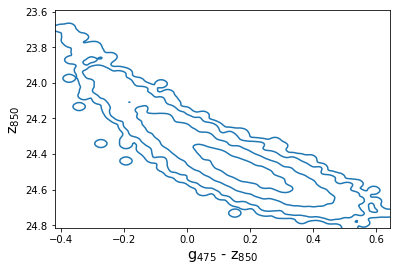

In [63]:
fig, [ax] = ppy.plotting.plot_pcmd_contours(pcmd)
ppy.plotting.plot_isochrone(iso_model, axes=ax)

In [27]:
from drizzlepac import sky
sky.sky(outputs['F850LP'])

NoCfgFileError: No valid .cfg files found in package: "drizzlepac.sky" for task: "sky"